In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
14,5.8,4.0,1.2,0.2,Iris-setosa
18,5.7,3.8,1.7,0.3,Iris-setosa
100,6.3,3.3,6.0,2.5,Iris-virginica
33,5.5,4.2,1.4,0.2,Iris-setosa
104,6.5,3.0,5.8,2.2,Iris-virginica
...,...,...,...,...,...
43,5.0,3.5,1.6,0.6,Iris-setosa
86,6.7,3.1,4.7,1.5,Iris-versicolor
101,5.8,2.7,5.1,1.9,Iris-virginica
119,6.0,2.2,5.0,1.5,Iris-virginica


In [3]:
labels_column_name = "label"
jackknife_idx = np.random.randint(0, iris_dataset.shape[0])
train_set = iris_dataset.loc[
        iris_dataset.index != jackknife_idx
    ].drop(columns=labels_column_name).values
train_labels = iris_dataset.loc[
        iris_dataset.index != jackknife_idx,
        labels_column_name
    ].values
test_set = iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ].drop(columns=labels_column_name).values
test_labels = iris_dataset.loc[
        iris_dataset.index == jackknife_idx,
        labels_column_name
    ].values
test_instance = test_set[0]

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)

random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 10)
random_forest.fit(train_set, train_labels)
unique_labels = random_forest.classes_

prediction = random_forest.predict(test_set)
prediction_probabilities = random_forest.predict_proba(test_set)
print(f"Predicted: {prediction}. Probabilities: {prediction_probabilities}")

Predicted: ['Iris-setosa']. Probabilities: [[1. 0. 0.]]


### Use LIME to explain prediction

,sepal_length,sepal_width,petal_length,petal_width,label
37,4.9,3.1,1.5,0.1,Iris-setosa


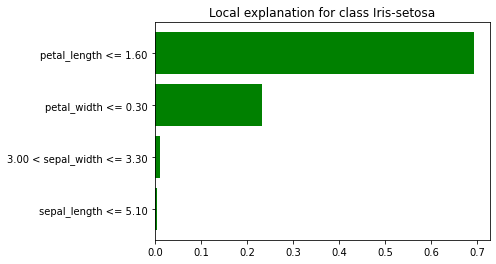

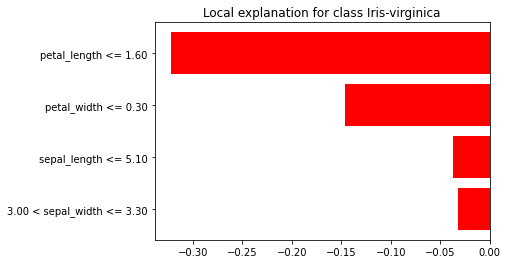

In [4]:
importlib.reload(lime.lime_tabular_mod)
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = unique_labels
)
explanation = explainer.explain_instance(
    test_instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
for label in explanation.top_labels[:2]:
    _ = explanation.as_pyplot_figure(label)
iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ]

In [5]:
print(explanation.get_probabilities_for_explained_model())
print(explanation.get_probabilities_for_surrogate_model(order="ordered"))
print(explanation.get_probabilities_for_surrogate_model(normalized=True, order="ordered"))
print(explanation.get_scores_for_surrogate_model(order="ordered"))
print(explanation.get_fidelity_loss())


[1. 0. 0.]
[0.8743208330123302, 0.338876423324486, 0.29508092820585385]
[0.46604117 0.27282473 0.2611341 ]
[0.9868571282968062, 0.1364759240853513, -0.12333305238215775]
0.7430003629475072


In [6]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.692991021347427),
 (3, 0.23275258158384068),
 (1, 0.01106223132853597),
 (0, 0.005011636303621702)]

In [7]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, -0.32240364777551045),
 (3, -0.14662251088555653),
 (0, -0.03656623085480219),
 (1, -0.03185704896833466)]

In [8]:
explanation.as_map()

{1: [(2, -0.3705873735719167),
  (3, -0.08613007069828427),
  (0, 0.03155459455118051),
  (1, 0.02079481763979868)],
 2: [(2, -0.32240364777551045),
  (3, -0.14662251088555653),
  (0, -0.03656623085480219),
  (1, -0.03185704896833466)],
 0: [(2, 0.692991021347427),
  (3, 0.23275258158384068),
  (1, 0.01106223132853597),
  (0, 0.005011636303621702)]}

In [9]:
explainer.discretizer.names

{0: ['sepal_length <= 5.10',
  '5.10 < sepal_length <= 5.80',
  '5.80 < sepal_length <= 6.40',
  'sepal_length > 6.40'],
 1: ['sepal_width <= 2.80',
  '2.80 < sepal_width <= 3.00',
  '3.00 < sepal_width <= 3.30',
  'sepal_width > 3.30'],
 2: ['petal_length <= 1.60',
  '1.60 < petal_length <= 4.40',
  '4.40 < petal_length <= 5.10',
  'petal_length > 5.10'],
 3: ['petal_width <= 0.30',
  '0.30 < petal_width <= 1.30',
  '1.30 < petal_width <= 1.80',
  'petal_width > 1.80']}

In [10]:
explainer.discretizer.maxs


{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.4, 5.1, 6.9],
 3: [0.3, 1.3, 1.8, 2.5]}